In [ ]:
# %%
# --- Imports and Config ---
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import random

# --- Configuration ---
N_LAGS = 14 # Number of past time steps to use as input sequence
N_LEADS = 6 # Predict 6 days ahead (+ current day view)
SPLIT_DATE = '2016-06-01'
DO_LOG_TRANSFORM = True # Apply log1p transform to Views
SCALE_TARGETS = True # Scale the target variables
# Dropped N_ROLLING_WINDOW as we are not creating it in this version

# Load the data
data = pd.read_csv('../data/train_1/train_1.csv')
print("Original data shape:", data.shape)

# --- Initial Page Parsing (Keep as is) ---
mask = data['Page'].str.split('_').apply(lambda x: len(x) != 4)
problem_rows = data[mask]
if not problem_rows.empty:
    print("Warning: Rows with unexpected Page format found.")

pattern = r'^(?P<Title>.+)_(?P<Project>[^_]+)_(?P<Access>[^_]+)_(?P<Agent>[^_]+)$'
data[['Title', 'Project', 'Access', 'Agent']] = data['Page'].str.extract(pattern, expand=False)

problem_rows = data[data[['Title', 'Project', 'Access', 'Agent']].isnull().any(axis=1)]
if not problem_rows.empty:
   print("Problem rows after regex extraction:")
   print(problem_rows[['Page']].head())

data = data.drop(columns=['Title'])
data['Title'] = data['Page']
data = data.drop(columns=['Page'])
data.drop(['Access', 'Agent', 'Title'], axis=1, inplace=True)

# --- Project Feature Engineering (Keep as is) ---
data['CountryCode'] = data['Project'].str.extract(r'^(.*?)\.wikipedia\.org$', expand=False)
data['CountryCode'].fillna('unknown', inplace=True)
data['Project_numeric'] = pd.factorize(data['CountryCode'])[0] + 1
data.drop(columns=['CountryCode', 'Project'], inplace=True)

# --- Aggregation by Project (Keep as is) ---
date_columns = data.columns[data.columns.str.match(r'\d{4}-\d{2}-\d{2}')]
df_merged = data.groupby('Project_numeric')[date_columns].sum().reset_index()
print("Grouped data shape:", df_merged.shape)


# --- Feature Engineering (Reworked for Multi-Feature Sequence) ---
print("Starting Feature Engineering...")
# Melt the dataframe
date_columns_list = df_merged.columns[df_merged.columns.str.match(r'\d{4}-\d{2}-\d{2}')].tolist()
df_long = df_merged.melt(id_vars=['Project_numeric'],
                         value_vars=date_columns_list,
                         var_name='Date',
                         value_name='Views')

df_long['Date'] = pd.to_datetime(df_long['Date'])
df_long['Views'] = pd.to_numeric(df_long['Views'], errors='coerce')
df_long['Views'].fillna(0, inplace=True)
df_long.sort_values(by=['Project_numeric', 'Date'], inplace=True)
df_long.reset_index(drop=True)

# --- 1. Calculate Base Features for Each Time Step ---
# Log Transform (Optional but Recommended)
if DO_LOG_TRANSFORM:
    df_long['LogViews'] = np.log1p(df_long['Views'])
    print("Applied log1p transformation to Views.")
    value_col = 'LogViews'
else:
    value_col = 'Views'

# Create Date Features (needed for cyclical encoding)
df_long['dayofweek'] = df_long['Date'].dt.dayofweek
df_long['month'] = df_long['Date'].dt.month
df_long['dayofyear'] = df_long['Date'].dt.dayofyear

# Create Cyclical Date Features
print("Creating cyclical date features...")
df_long['dayofweek_sin'] = np.sin(2 * np.pi * df_long['dayofweek'] / 7.0)
df_long['dayofweek_cos'] = np.cos(2 * np.pi * df_long['dayofweek'] / 7.0)
df_long['month_sin'] = np.sin(2 * np.pi * df_long['month'] / 12.0)
df_long['month_cos'] = np.cos(2 * np.pi * df_long['month'] / 12.0)
df_long['dayofyear_sin'] = np.sin(2 * np.pi * df_long['dayofyear'] / 365.25)
df_long['dayofyear_cos'] = np.cos(2 * np.pi * df_long['dayofyear'] / 365.25)

# Define the list of features that constitute ONE time step
# These are the features we will create lagged versions of
base_features_to_lag = [
    value_col, # The actual value (LogViews or Views)
    'Project_numeric', # Project ID (constant within group, but we lag it)
    'dayofweek_sin', 'dayofweek_cos',
    'month_sin', 'month_cos',
    'dayofyear_sin', 'dayofyear_cos'
]
print(f"Base features per time step ({len(base_features_to_lag)}): {base_features_to_lag}")

# --- 2. Create Lags for ALL Base Features ---
print(f"Creating lags (1 to {N_LAGS}) for all base features...")
lag_cols = []
for i in range(1, N_LAGS + 1):
    for feat in base_features_to_lag:
        lag_col_name = f'{feat}_lag{i}'
        df_long[lag_col_name] = df_long.groupby('Project_numeric')[feat].shift(i)
        lag_cols.append(lag_col_name)

# --- 3. Create Lead Features (Targets) ---
# Targets are based on the original value column (value_col)
print(f"Creating {N_LEADS} lead features (targets)...")
target_features = [value_col] # Include current value as first target
for i in range(1, N_LEADS + 1):
    lead_col_name = f'lead{i}'
    df_long[lead_col_name] = df_long.groupby('Project_numeric')[value_col].shift(-i)
    target_features.append(lead_col_name)

# --- 4. Drop Rows with NaNs ---
# NaNs are created by lags and leads. We need all lag columns and all target columns to be non-NaN.
print("Dropping rows with NaNs...")
initial_rows = df_long.shape[0]
cols_to_check_for_nan = lag_cols + target_features # Check all generated lag and lead cols
df_long.dropna(subset=cols_to_check_for_nan, inplace=True)
print(f"Dropped {initial_rows - df_long.shape[0]} rows due to NaNs.")
print("Final DataFrame shape after FE:", df_long.shape)

# --- 5. Split data ---
print(f"\nSplitting data at {SPLIT_DATE}...")
train_df = df_long[df_long['Date'] < SPLIT_DATE].copy()
test_df = df_long[df_long['Date'] >= SPLIT_DATE].copy()
print(f"Train df shape: {train_df.shape}")
print(f"Test df shape: {test_df.shape}")

# --- 6. Scaling ---
# Scale the *lagged* features. Fit only on train data.
print(f"Scaling {len(lag_cols)} lagged features...")
scaler_seq = StandardScaler()
train_df[lag_cols] = scaler_seq.fit_transform(train_df[lag_cols])
test_df[lag_cols] = scaler_seq.transform(test_df[lag_cols])
print("Lagged sequence features scaled.")

# Scale target features (Optional)
if SCALE_TARGETS:
    scaler_target = StandardScaler()
    train_df[target_features] = scaler_target.fit_transform(train_df[target_features])
    test_df[target_features] = scaler_target.transform(test_df[target_features])
    print("Target features scaled.")
else:
    print("Target features were NOT scaled.")

TARGETS_SCALED = SCALE_TARGETS # Flag for inverse transform later

# --- 7. Prepare Tensors (with Reshaping) ---
print("\nCreating tensors with sequence reshaping...")
num_features_per_step = len(base_features_to_lag)

def create_sequence_tensors(df, lag_cols, target_cols, n_lags, n_features):
    # Order lag columns correctly: feat1_lagN, feat2_lagN, ..., featN_lagN, feat1_lagN-1, ... featN_lag1
    ordered_lag_cols = []
    for k in range(n_lags, 0, -1): # From lagN down to lag1
        for feat in base_features_to_lag: # In the defined base feature order
            ordered_lag_cols.append(f'{feat}_lag{k}')

    # Select scaled lagged data
    X_flat = df[ordered_lag_cols].values

    # Reshape into (num_samples, sequence_length, num_features_per_step)
    num_samples = X_flat.shape[0]
    X_seq = torch.tensor(X_flat, dtype=torch.float32).reshape(num_samples, n_lags, n_features)

    # Get target data
    y = torch.tensor(df[target_cols].values, dtype=torch.float32)

    return X_seq, y

X_train_seq, y_train = create_sequence_tensors(train_df, lag_cols, target_features, N_LAGS, num_features_per_step)
X_test_seq, y_test = create_sequence_tensors(test_df, lag_cols, target_features, N_LAGS, num_features_per_step)

print("Train tensors shape:", X_train_seq.shape, y_train.shape) # No context tensor needed
print("Test tensors shape:", X_test_seq.shape, y_test.shape)

# --- Store Test Dates ---
print("Storing test dates...")
test_dates_list = test_df['Date'].tolist()
print(f"Stored {len(test_dates_list)} dates from the test set.")

# --- Clean up ---
print("Deleting pandas DataFrames to free memory...")
del df_long, train_df, test_df, data, df_merged
print("DataFrames deleted.")
print("\n--- Data Preparation Cell Complete ---")# %%
# --- Imports and Config ---
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import random

# --- Configuration ---
N_LAGS = 14 # Number of past time steps to use as input sequence
N_LEADS = 6 # Predict 6 days ahead (+ current day view)
SPLIT_DATE = '2016-06-01'
DO_LOG_TRANSFORM = True # Apply log1p transform to Views
SCALE_TARGETS = True # Scale the target variables
# Dropped N_ROLLING_WINDOW as we are not creating it in this version

# Load the data
data = pd.read_csv('../data/train_1/train_1.csv')
print("Original data shape:", data.shape)

# --- Initial Page Parsing (Keep as is) ---
mask = data['Page'].str.split('_').apply(lambda x: len(x) != 4)
problem_rows = data[mask]
if not problem_rows.empty:
    print("Warning: Rows with unexpected Page format found.")

pattern = r'^(?P<Title>.+)_(?P<Project>[^_]+)_(?P<Access>[^_]+)_(?P<Agent>[^_]+)$'
data[['Title', 'Project', 'Access', 'Agent']] = data['Page'].str.extract(pattern, expand=False)

problem_rows = data[data[['Title', 'Project', 'Access', 'Agent']].isnull().any(axis=1)]
if not problem_rows.empty:
   print("Problem rows after regex extraction:")
   print(problem_rows[['Page']].head())

data = data.drop(columns=['Title'])
data['Title'] = data['Page']
data = data.drop(columns=['Page'])
data.drop(['Access', 'Agent', 'Title'], axis=1, inplace=True)

# --- Project Feature Engineering (Keep as is) ---
data['CountryCode'] = data['Project'].str.extract(r'^(.*?)\.wikipedia\.org$', expand=False)
data['CountryCode'].fillna('unknown', inplace=True)
data['Project_numeric'] = pd.factorize(data['CountryCode'])[0] + 1
data.drop(columns=['CountryCode', 'Project'], inplace=True)

# --- Aggregation by Project (Keep as is) ---
date_columns = data.columns[data.columns.str.match(r'\d{4}-\d{2}-\d{2}')]
df_merged = data.groupby('Project_numeric')[date_columns].sum().reset_index()
print("Grouped data shape:", df_merged.shape)


# --- Feature Engineering (Reworked for Multi-Feature Sequence) ---
print("Starting Feature Engineering...")
# Melt the dataframe
date_columns_list = df_merged.columns[df_merged.columns.str.match(r'\d{4}-\d{2}-\d{2}')].tolist()
df_long = df_merged.melt(id_vars=['Project_numeric'],
                         value_vars=date_columns_list,
                         var_name='Date',
                         value_name='Views')

df_long['Date'] = pd.to_datetime(df_long['Date'])
df_long['Views'] = pd.to_numeric(df_long['Views'], errors='coerce')
df_long['Views'].fillna(0, inplace=True)
df_long.sort_values(by=['Project_numeric', 'Date'], inplace=True)
df_long.reset_index(drop=True)

# --- 1. Calculate Base Features for Each Time Step ---
# Log Transform (Optional but Recommended)
if DO_LOG_TRANSFORM:
    df_long['LogViews'] = np.log1p(df_long['Views'])
    print("Applied log1p transformation to Views.")
    value_col = 'LogViews'
else:
    value_col = 'Views'

# Create Date Features (needed for cyclical encoding)
df_long['dayofweek'] = df_long['Date'].dt.dayofweek
df_long['month'] = df_long['Date'].dt.month
df_long['dayofyear'] = df_long['Date'].dt.dayofyear

# Create Cyclical Date Features
print("Creating cyclical date features...")
df_long['dayofweek_sin'] = np.sin(2 * np.pi * df_long['dayofweek'] / 7.0)
df_long['dayofweek_cos'] = np.cos(2 * np.pi * df_long['dayofweek'] / 7.0)
df_long['month_sin'] = np.sin(2 * np.pi * df_long['month'] / 12.0)
df_long['month_cos'] = np.cos(2 * np.pi * df_long['month'] / 12.0)
df_long['dayofyear_sin'] = np.sin(2 * np.pi * df_long['dayofyear'] / 365.25)
df_long['dayofyear_cos'] = np.cos(2 * np.pi * df_long['dayofyear'] / 365.25)

# Define the list of features that constitute ONE time step
# These are the features we will create lagged versions of
base_features_to_lag = [
    value_col, # The actual value (LogViews or Views)
    'Project_numeric', # Project ID (constant within group, but we lag it)
    'dayofweek_sin', 'dayofweek_cos',
    'month_sin', 'month_cos',
    'dayofyear_sin', 'dayofyear_cos'
]
print(f"Base features per time step ({len(base_features_to_lag)}): {base_features_to_lag}")
# --- 2. Create Lags for ALL Base Features (More Efficiently) ---
print(f"Creating lags (1 to {N_LAGS}) for all base features (optimized)...")
lag_data = {} # Dictionary to hold new series
for i in range(1, N_LAGS + 1):
    for feat in base_features_to_lag:
        lag_col_name = f'{feat}_lag{i}'
        # Calculate the shifted series and store it
        lag_data[lag_col_name] = df_long.groupby('Project_numeric')[feat].shift(i)

# Create a DataFrame from the collected lag series
lag_df = pd.DataFrame(lag_data)
lag_cols = lag_df.columns.tolist() # Get the list of created lag column names

# --- 3. Create Lead Features (Targets) (More Efficiently) ---
print(f"Creating {N_LEADS} lead features (targets) (optimized)...")
lead_data = {} # Dictionary for lead series
target_features = [value_col] # Start with the base value column
for i in range(1, N_LEADS + 1):
    lead_col_name = f'lead{i}'
    # Calculate the shifted series and store it
    lead_data[lead_col_name] = df_long.groupby('Project_numeric')[value_col].shift(-i)
    target_features.append(lead_col_name)

# Create a DataFrame from the collected lead series
lead_df = pd.DataFrame(lead_data)

# --- Combine original df_long with new lag and lead DataFrames ---
print("Concatenating features into DataFrame...")
df_long = pd.concat([df_long, lag_df, lead_df], axis=1)
print("Concatenation complete.")


# --- 4. Drop Rows with NaNs ---
# (Keep this section as is)
print("Dropping rows with NaNs...")
initial_rows = df_long.shape[0]
cols_to_check_for_nan = lag_cols + target_features # Check all generated lag and lead cols
df_long.dropna(subset=cols_to_check_for_nan, inplace=True)
print(f"Dropped {initial_rows - df_long.shape[0]} rows due to NaNs.")
print("Final DataFrame shape after FE:", df_long.shape)
display(df_long.head(5))


# --- 5. Split data ---
print(f"\nSplitting data at {SPLIT_DATE}...")
train_df = df_long[df_long['Date'] < SPLIT_DATE].copy()
test_df = df_long[df_long['Date'] >= SPLIT_DATE].copy()
print(f"Train df shape: {train_df.shape}")
print(f"Test df shape: {test_df.shape}")

# --- 6. Scaling ---
# Scale the *lagged* features. Fit only on train data.
print(f"Scaling {len(lag_cols)} lagged features...")
scaler_seq = StandardScaler()
train_df[lag_cols] = scaler_seq.fit_transform(train_df[lag_cols])
test_df[lag_cols] = scaler_seq.transform(test_df[lag_cols])
print("Lagged sequence features scaled.")

# Scale target features (Optional)
if SCALE_TARGETS:
    scaler_target = StandardScaler()
    train_df[target_features] = scaler_target.fit_transform(train_df[target_features])
    test_df[target_features] = scaler_target.transform(test_df[target_features])
    print("Target features scaled.")
else:
    print("Target features were NOT scaled.")

TARGETS_SCALED = SCALE_TARGETS # Flag for inverse transform later

# --- 7. Prepare Tensors (with Reshaping) ---
print("\nCreating tensors with sequence reshaping...")
num_features_per_step = len(base_features_to_lag)

def create_sequence_tensors(df, lag_cols, target_cols, n_lags, n_features):
    # Order lag columns correctly: feat1_lagN, feat2_lagN, ..., featN_lagN, feat1_lagN-1, ... featN_lag1
    ordered_lag_cols = []
    for k in range(n_lags, 0, -1): # From lagN down to lag1
        for feat in base_features_to_lag: # In the defined base feature order
            ordered_lag_cols.append(f'{feat}_lag{k}')

    # Select scaled lagged data
    X_flat = df[ordered_lag_cols].values

    # Reshape into (num_samples, sequence_length, num_features_per_step)
    num_samples = X_flat.shape[0]
    X_seq = torch.tensor(X_flat, dtype=torch.float32).reshape(num_samples, n_lags, n_features)

    # Get target data
    y = torch.tensor(df[target_cols].values, dtype=torch.float32)

    return X_seq, y

X_train_seq, y_train = create_sequence_tensors(train_df, lag_cols, target_features, N_LAGS, num_features_per_step)
display(X_train_seq.shape, y_train.shape) # No context tensor needed
display(X_train_seq[0], y_train[0])
X_test_seq, y_test = create_sequence_tensors(test_df, lag_cols, target_features, N_LAGS, num_features_per_step)

print("Train tensors shape:", X_train_seq.shape, y_train.shape) # No context tensor needed
print("Test tensors shape:", X_test_seq.shape, y_test.shape)

# --- Store Test Dates ---
print("Storing test dates...")
test_dates_list = test_df['Date'].tolist()
print(f"Stored {len(test_dates_list)} dates from the test set.")

# --- Clean up ---
print("Deleting pandas DataFrames to free memory...")
del df_long, train_df, test_df, data, df_merged
print("DataFrames deleted.")
print("\n--- Data Preparation Cell Complete ---")


Original data shape: (145063, 551)


/tmp/ipykernel_73793/386902214.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['CountryCode'].fillna('unknown', inplace=True)
/tmp/ipykernel_73793/386902214.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

Grouped data shape: (8, 551)
Starting Feature Engineering...
Applied log1p transformation to Views.
Creating cyclical date features...
Base features per time step (8): ['LogViews', 'Project_numeric', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos']
Creating lags (1 to 14) for all base features...
Creating 6 lead features (targets)...
Dropping rows with NaNs...
Dropped 160 rows due to NaNs.
Final DataFrame shape after FE: (4240, 131)

Splitting data at 2016-06-01...
Train df shape: (2576, 131)
Test df shape: (1664, 131)
Scaling 112 lagged features...
Lagged sequence features scaled.
Target features scaled.

Creating tensors with sequence reshaping...
Train tensors shape: torch.Size([2576, 14, 8]) torch.Size([2576, 7])
Test tensors shape: torch.Size([1664, 14, 8]) torch.Size([1664, 7])
Storing test dates...
Stored 1664 dates from the test set.
Deleting pandas DataFrames to free memory...
DataFrames deleted.

--- Data Preparation Cell Complete 

/tmp/ipykernel_73793/386902214.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_long[lag_col_name] = df_long.groupby('Project_numeric')[feat].shift(i)
/tmp/ipykernel_73793/386902214.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_long[lag_col_name] = df_long.groupby('Project_numeric')[feat].shift(i)
/tmp/ipykernel_73793/386902214.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

Original data shape: (145063, 551)


/tmp/ipykernel_73793/386902214.py:241: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['CountryCode'].fillna('unknown', inplace=True)
/tmp/ipykernel_73793/386902214.py:262: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

Grouped data shape: (8, 551)
Starting Feature Engineering...
Applied log1p transformation to Views.
Creating cyclical date features...
Base features per time step (8): ['LogViews', 'Project_numeric', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos']
Creating lags (1 to 14) for all base features (optimized)...
Creating 6 lead features (targets) (optimized)...
Concatenating features into DataFrame...
Concatenation complete.
Dropping rows with NaNs...
Dropped 160 rows due to NaNs.
Final DataFrame shape after FE: (4240, 131)


,Project_numeric,Date,Views,LogViews,dayofweek,month,dayofyear,dayofweek_sin,dayofweek_cos,month_sin,...,month_sin_lag14,month_cos_lag14,dayofyear_sin_lag14,dayofyear_cos_lag14,lead1,lead2,lead3,lead4,lead5,lead6
112,1,2015-07-15,4224807.0,15.256484,2,7,196,0.974928,-0.222521,-0.5,...,-0.5,-0.866025,0.010751,-0.999942,15.253971,15.258272,15.299547,15.419477,15.358072,15.341736
120,1,2015-07-16,4214200.0,15.253971,3,7,197,0.433884,-0.900969,-0.5,...,-0.5,-0.866025,-0.006451,-0.999979,15.258272,15.299547,15.419477,15.358072,15.341736,15.354100
128,1,2015-07-17,4232365.0,15.258272,4,7,198,-0.433884,-0.900969,-0.5,...,-0.5,-0.866025,-0.023651,-0.999720,15.299547,15.419477,15.358072,15.341736,15.354100,15.237526
136,1,2015-07-18,4410712.0,15.299547,5,7,199,-0.974928,-0.222521,-0.5,...,-0.5,-0.866025,-0.040844,-0.999166,15.419477,15.358072,15.341736,15.354100,15.237526,15.096566
144,1,2015-07-19,4972716.0,15.419477,6,7,200,-0.781831,0.623490,-0.5,...,-0.5,-0.866025,-0.058026,-0.998315,15.358072,15.341736,15.354100,15.237526,15.096566,15.057933



Splitting data at 2016-06-01...
Train df shape: (2576, 131)
Test df shape: (1664, 131)
Scaling 112 lagged features...
Lagged sequence features scaled.
Target features scaled.

Creating tensors with sequence reshaping...
Train tensors shape: torch.Size([2576, 14, 8]) torch.Size([2576, 7])
Test tensors shape: torch.Size([1664, 14, 8]) torch.Size([1664, 7])
Storing test dates...
Stored 1664 dates from the test set.
Deleting pandas DataFrames to free memory...
DataFrames deleted.

--- Data Preparation Cell Complete ---


In [2]:

# --- Create DataLoaders ---
# Note: TensorDataset now only takes sequence and target tensors
batch_size = 128 # Adjust as needed based on memory

train_dataset = TensorDataset(X_train_seq, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Train DataLoader created with batch size {batch_size}.")

test_dataset = TensorDataset(X_test_seq, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle test data
print(f"Test DataLoader created with batch size {batch_size}.")


# --- Clean up pandas dataframes ---
print("Deleting pandas DataFrames to free memory...")
try:
    # Keep df_merged if needed for original aggregate plots
    del df_long, train_df, test_df, data # Keep df_merged if used elsewhere
    print("DataFrames deleted.")
except NameError as e:
    print(f"Warning: Could not delete a DataFrame: {e}. It might have been deleted already.")

print("\n--- Tensor/DataLoader Preparation Cell Complete ---")

Train DataLoader created with batch size 128.
Test DataLoader created with batch size 128.
Deleting pandas DataFrames to free memory...

--- Tensor/DataLoader Preparation Cell Complete ---


Using device: cuda
Derived SEQUENCE_INPUT_SIZE: 8
Derived OUTPUT_SIZE: 7

Model Architecture:
LSTMForecastModel(
  (lstm): LSTM(8, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
)

Total trainable parameters: 211463

Starting Training...
Epoch [1/30], Train Loss: 0.714788, Test Loss: 0.278981
Epoch [2/30], Train Loss: 0.108894, Test Loss: 0.038184
Epoch [3/30], Train Loss: 0.046902, Test Loss: 0.030106
Epoch [4/30], Train Loss: 0.043761, Test Loss: 0.030879
Epoch [5/30], Train Loss: 0.039859, Test Loss: 0.039335
Epoch [6/30], Train Loss: 0.036906, Test Loss: 0.034720
Epoch [7/30], Train Loss: 0.035583, Test Loss: 0.035047
Epoch [8/30], Train Loss: 0.033116, Test Loss: 0.033343
Epoch [9/30], Train Loss: 0.031134, Test Loss: 0.033063
Epoch [10/30], Train Loss: 0.029726, Test Loss: 0.032198
Epoch [11/30], Tra

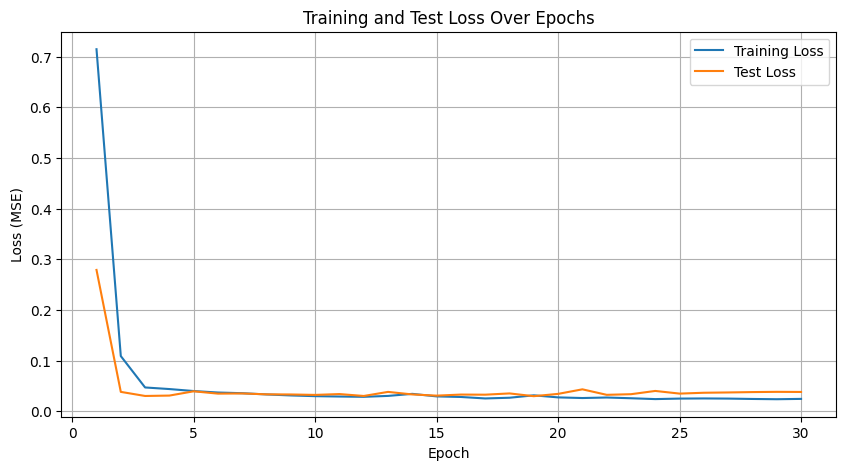


Calculating Final Evaluation Metrics...
Final Test MSE: 0.038027
Final Test RMSE: 0.195006
Final Test MAE: 0.125188

Note: Above metrics are on SCALED target data.
To get metrics in the original scale, inverse transform predictions and targets using 'scaler_target'.


In [3]:
# %%
# --- Define the Updated LSTM Model ---
# Removed static_input_size, adjusted LSTM input and fc1 input

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class LSTMForecastModel(nn.Module):
    # Removed static_input_size from arguments
    def __init__(self, sequence_input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sequence_input_size = sequence_input_size # Store this

        # LSTM layer processes the sequence input
        # sequence_input_size is now the number of features at each time step (e.g., 8)
        self.lstm = nn.LSTM(sequence_input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)

        # Linear layers process ONLY the LSTM output
        # Input to fc1 is now just hidden_size (or hidden_size * 2 if bidirectional)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2) # *** ADJUSTED INPUT SIZE ***
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)

    # Removed x_static from arguments
    def forward(self, x_seq):
        # Initialize hidden and cell states
        # Use self.num_layers and self.hidden_size
        h0 = torch.zeros(self.num_layers, x_seq.size(0), self.hidden_size).to(x_seq.device)
        c0 = torch.zeros(self.num_layers, x_seq.size(0), self.hidden_size).to(x_seq.device)

        # Pass sequence through LSTM
        # lstm_out shape: (batch, seq_len, hidden_size)
        # hidden shape: (num_layers, batch, hidden_size)
        # Ensure input x_seq has shape (batch, seq_len, features_per_step) -> (batch, N_LAGS, sequence_input_size)
        if x_seq.shape[2] != self.sequence_input_size:
             raise ValueError(f"Input sequence feature size ({x_seq.shape[2]}) does not match model expected size ({self.sequence_input_size})")

        lstm_out, (hidden, _) = self.lstm(x_seq, (h0, c0))

        # We use the hidden state of the last layer from the last time step
        # hidden shape is (num_layers, batch, hidden_size), hidden[-1] takes the last layer's state
        last_hidden_state = hidden[-1] # Shape: (batch, hidden_size)

        # --- Removed concatenation with static features ---

        # Pass through fully connected layers using only LSTM output
        out = self.fc1(last_hidden_state) # *** INPUT IS JUST LSTM STATE ***
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out) # Shape: (batch, output_size)
        return out

# --- Model, Loss, Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Hyperparameters ---
# ** IMPORTANT: Update sizes based on the previous cell's output **
# From previous output: X_train_seq.shape is torch.Size([2576, 14, 8]), y_train.shape is torch.Size([2576, 7])
SEQUENCE_INPUT_SIZE = 8  # Number of features per time step (len(base_features_to_lag))
# STATIC_INPUT_SIZE = len(static_features) # REMOVED - No longer needed
HIDDEN_SIZE = 128 # Increased hidden size - Can be tuned
NUM_LAYERS = 2     # Can be tuned
OUTPUT_SIZE = 7    # Number of target features (len(target_features))
LEARNING_RATE = 0.001
NUM_EPOCHS = 30    # Increased epochs - Start moderate, check validation loss
DROPOUT_PROB = 0.2 # Regularization

# Ensure base_features_to_lag and target_features are defined or get sizes from tensors
try:
    # Assuming X_train_seq and y_train exist from the previous cell
    SEQUENCE_INPUT_SIZE = X_train_seq.shape[2]
    OUTPUT_SIZE = y_train.shape[1]
    print(f"Derived SEQUENCE_INPUT_SIZE: {SEQUENCE_INPUT_SIZE}")
    print(f"Derived OUTPUT_SIZE: {OUTPUT_SIZE}")
except NameError:
    print("Warning: X_train_seq or y_train not found. Using manually set sizes.")
    # Manually set based on previous known output if needed, but derivation is better
    # SEQUENCE_INPUT_SIZE = 8
    # OUTPUT_SIZE = 7


# Instantiate the updated model (without static_input_size)
model = LSTMForecastModel(
    sequence_input_size=SEQUENCE_INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=OUTPUT_SIZE,
    dropout_prob=DROPOUT_PROB
).to(device)

criterion = nn.MSELoss() # Mean Squared Error Loss (suitable for scaled data)
# criterion = nn.L1Loss() # Mean Absolute Error Loss (less sensitive to outliers)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam is usually a good default

print("\nModel Architecture:")
print(model)
# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params}")


# %%
# --- Training Loop ---
# Updated loop to unpack only seq_data, targets

train_losses = []
test_losses = []

print("\nStarting Training...")
for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0
    # *** UPDATED: Unpack only seq_data, targets ***
    for batch_idx, (seq_data, targets) in enumerate(train_loader):
        # Move data to device
        # *** UPDATED: Removed static_data ***
        seq_data, targets = seq_data.to(device), targets.to(device)

        # Forward pass
        # *** UPDATED: Model call uses only seq_data ***
        outputs = model(seq_data)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        # Optional: Gradient Clipping (can help stabilize training)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # --- Validation ---
    model.eval()  # Set model to evaluation mode
    running_test_loss = 0.0
    with torch.no_grad():
        # *** UPDATED: Unpack only seq_data, targets ***
        for seq_data, targets in test_loader:
            # Move data to device
            # *** UPDATED: Removed static_data ***
            seq_data, targets = seq_data.to(device), targets.to(device)

            # Forward pass
            # *** UPDATED: Model call uses only seq_data ***
            outputs = model(seq_data)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item()

    epoch_test_loss = running_test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {epoch_train_loss:.6f}, Test Loss: {epoch_test_loss:.6f}")

    # Basic Early Stopping Check (Optional but recommended)
    # if epoch > 10 and epoch_test_loss > min(test_losses[-5:]): # Example: Stop if loss increases over last 5 epochs after epoch 10
    #      print("Early stopping triggered.")
    #      break

print("Training finished.")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss') # Use len(train_losses) in case of early stopping
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# %%
# --- Final Evaluation Metrics ---
# Updated loop to unpack only seq_data, targets

print("\nCalculating Final Evaluation Metrics...")
model.eval()
total_test_loss_mse = 0.0
total_test_loss_mae = 0.0
mae_criterion = nn.L1Loss() # Define MAE loss for calculation

with torch.no_grad():
    # *** UPDATED: Unpack only seq_data, targets ***
    for seq_data, targets in test_loader:
        # Move data to device
        # *** UPDATED: Removed static_data ***
        seq_data, targets = seq_data.to(device), targets.to(device)

        # Forward pass
        # *** UPDATED: Model call uses only seq_data ***
        outputs = model(seq_data)

        # Calculate losses for the batch and accumulate (weighted by batch size)
        total_test_loss_mse += criterion(outputs, targets).item() * targets.size(0)
        total_test_loss_mae += mae_criterion(outputs, targets).item() * targets.size(0)

# Calculate average losses over the entire test dataset
# Ensure test_dataset is available or use len(X_test_seq)
try:
    dataset_size = len(test_dataset)
except NameError:
    try:
       dataset_size = len(X_test_seq) # Fallback if test_dataset was deleted somehow
    except NameError:
       print("Warning: Cannot determine test dataset size. Metrics might be inaccurate.")
       dataset_size = 1 # Avoid division by zero

if dataset_size > 0:
    final_mse = total_test_loss_mse / dataset_size
    final_rmse = np.sqrt(final_mse)
    final_mae = total_test_loss_mae / dataset_size

    print(f"Final Test MSE: {final_mse:.6f}")
    print(f"Final Test RMSE: {final_rmse:.6f}")
    print(f"Final Test MAE: {final_mae:.6f}")

    # Remind user about scaling
    if TARGETS_SCALED:
        print("\nNote: Above metrics are on SCALED target data.")
        print("To get metrics in the original scale, inverse transform predictions and targets using 'scaler_target'.")
    else:
        print("\nNote: Above metrics are on ORIGINAL target data (as targets were not scaled).")

else:
    print("Test dataset size is zero. Cannot calculate final metrics.")

Length of test_dataset: 1664
Length of test_dates_list: 1664
Plotting 7 target days.
Processing plot for test index 972...
Index 972: Applied expm1 for log transform.
Processing plot for test index 486...
Index 486: Applied expm1 for log transform.
Processing plot for test index 641...
Index 641: Applied expm1 for log transform.
Processing plot for test index 763...
Index 763: Applied expm1 for log transform.
Processing plot for test index 186...
Index 186: Applied expm1 for log transform.
Processing plot for test index 669...
Index 669: Applied expm1 for log transform.
Processing plot for test index 1454...
Index 1454: Applied expm1 for log transform.


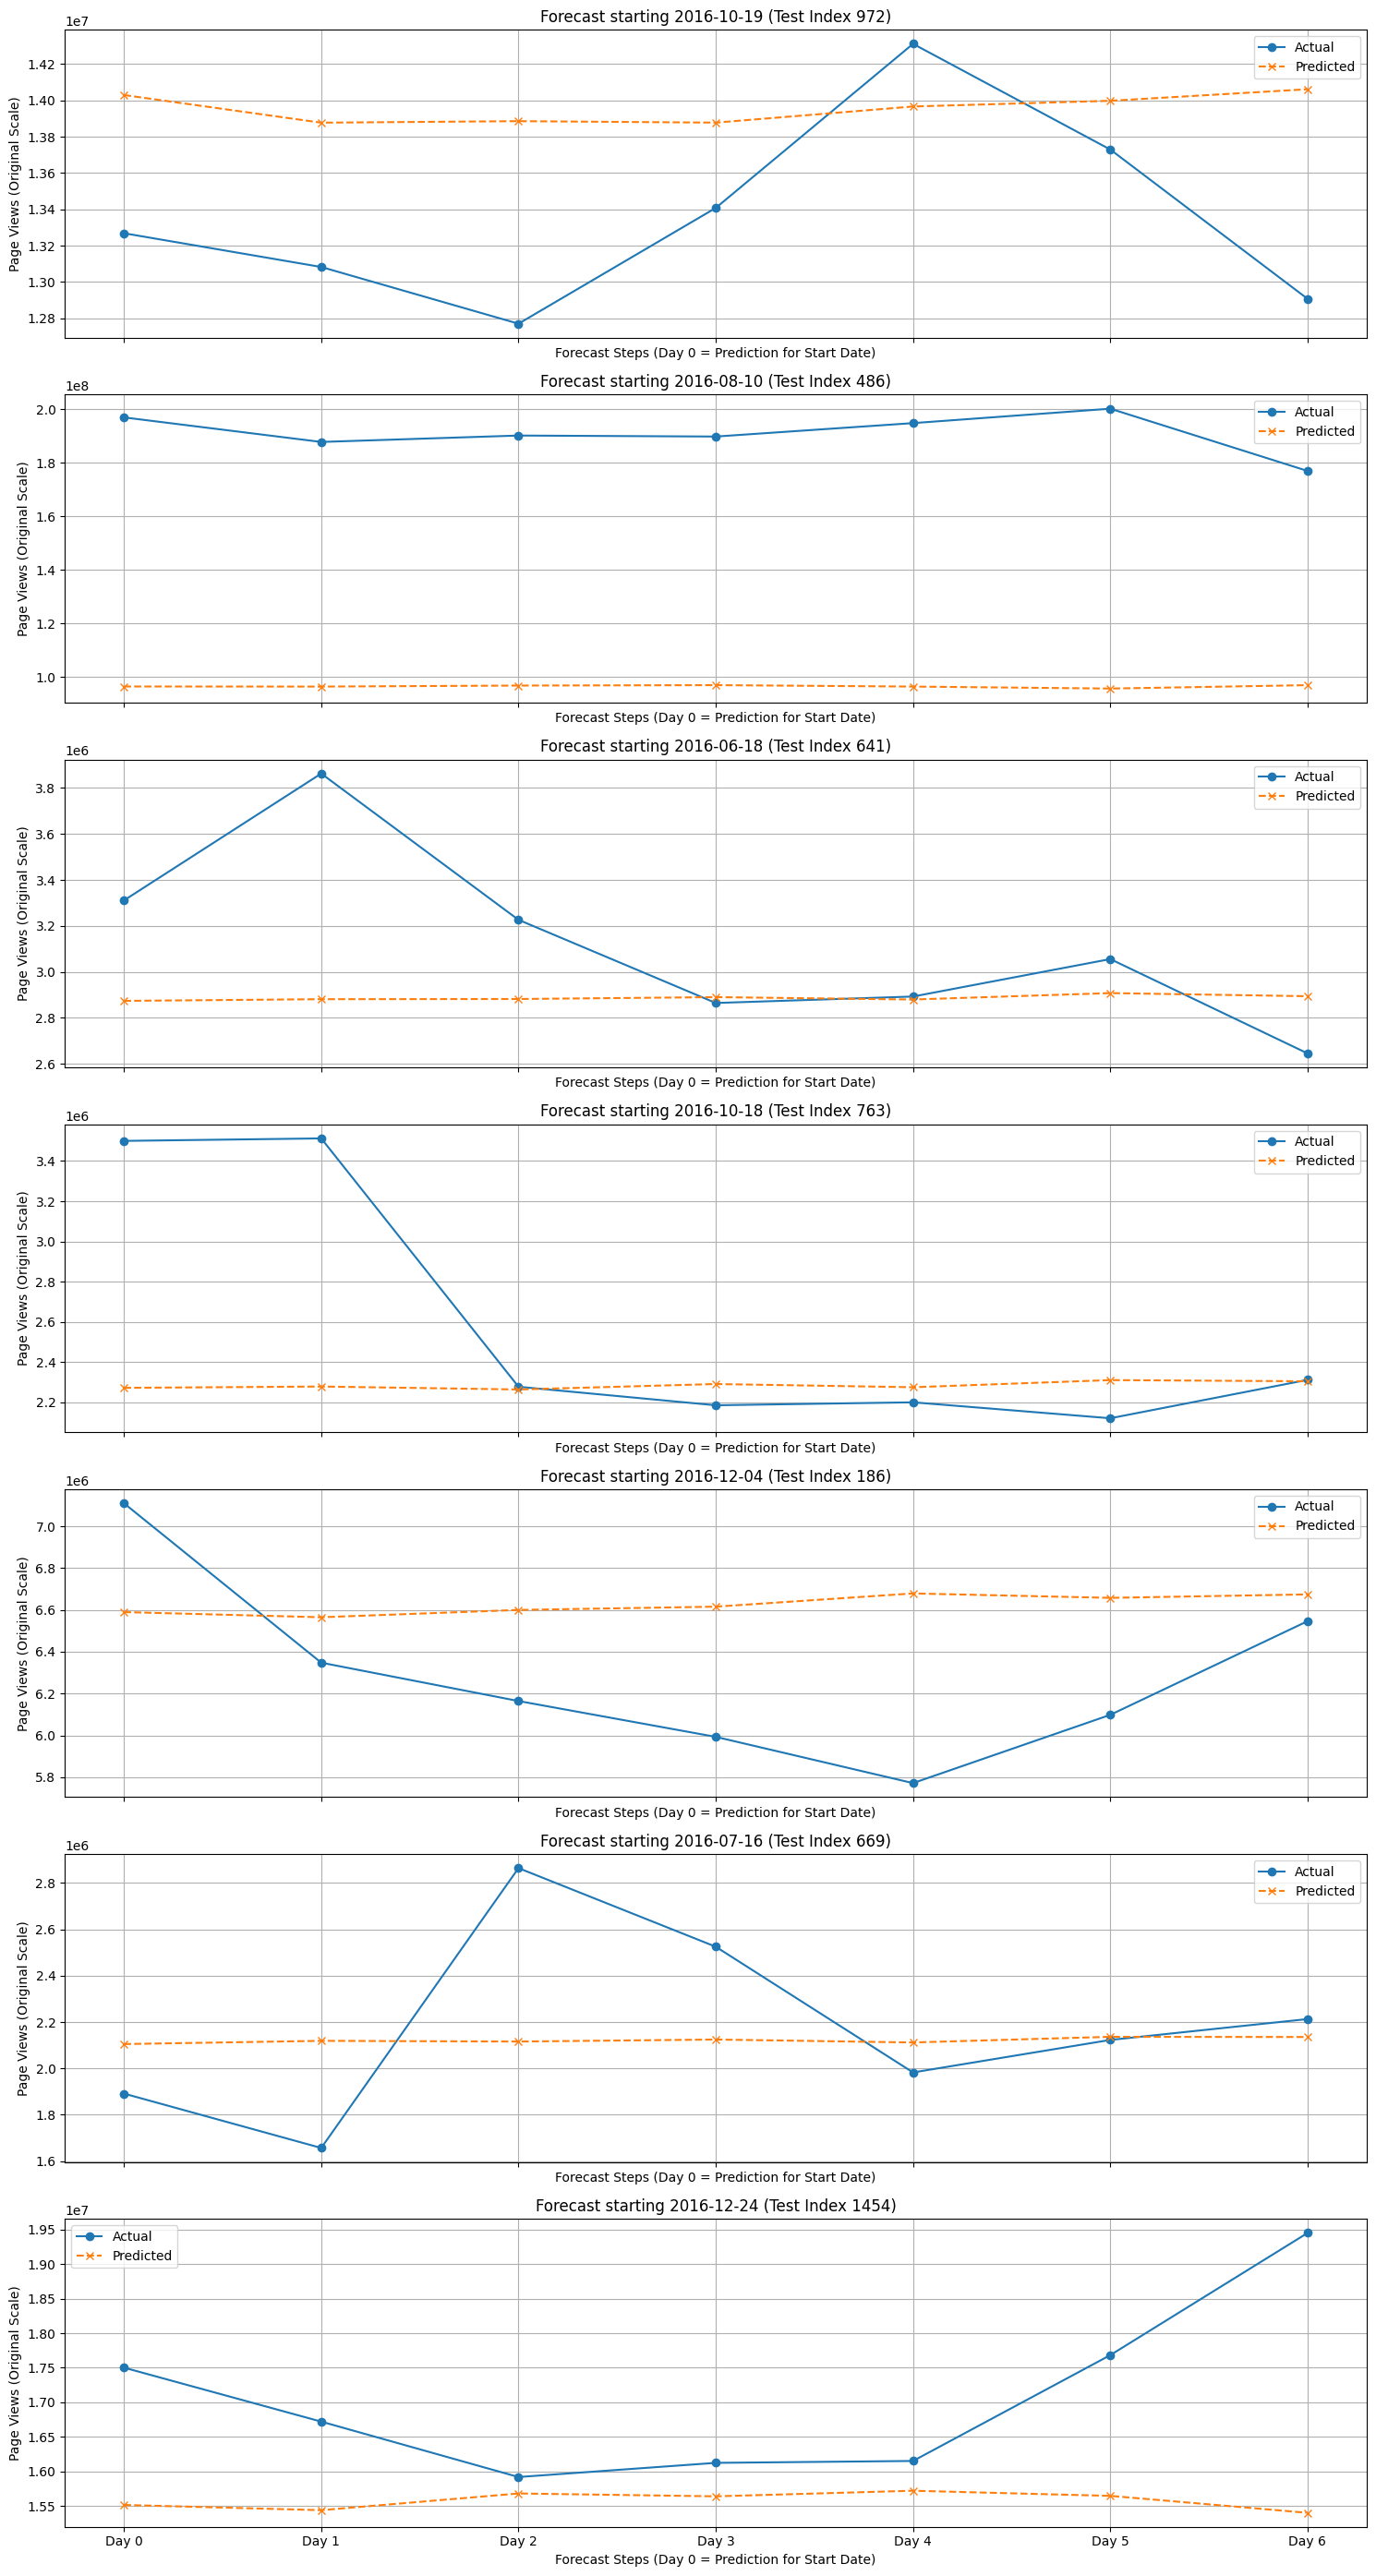

In [4]:
# %%
# --- Prediction and Visualization ---
# Needs to align with the latest model (no static inputs) and dataset structure

import matplotlib.pyplot as plt
import random
import torch
import numpy as np

# Check if essential variables exist
essential_vars = ['test_dataset', 'test_dates_list', 'model', 'device', 'TARGETS_SCALED']
if TARGETS_SCALED:
    essential_vars.append('scaler_target')

vars_exist = True
for var_name in essential_vars:
    if var_name not in locals():
        print(f"ERROR: Essential variable '{var_name}' is not defined.")
        print("Please ensure the previous cells (data prep, model definition, training) were run successfully.")
        vars_exist = False

if vars_exist:
    print(f"Length of test_dataset: {len(test_dataset)}")
    print(f"Length of test_dates_list: {len(test_dates_list)}")
    if len(test_dataset) != len(test_dates_list):
         print("Warning: Length mismatch between test_dataset and test_dates_list!")

    # Define target labels for plotting axis (assuming 7 targets: current + 6 leads)
    # Adjust if N_LEADS or target definition changes
    try:
        num_targets = y_test.shape[1] # Get number of targets from test tensor shape
        target_labels = [f'Day {i}' for i in range(num_targets)] # e.g., Day 0, Day 1,... Day 6
        forecast_horizon = list(range(num_targets))
        print(f"Plotting {num_targets} target days.")
    except NameError:
        print("Warning: y_test not found, assuming 7 target days for plotting.")
        num_targets = 7
        target_labels = [f'Day {i}' for i in range(num_targets)]
        forecast_horizon = list(range(num_targets))


    # --- Plotting Setup ---
    num_samples_to_plot = 7 # Number of random examples to plot
    if len(test_dataset) == 0:
        print("Test dataset is empty. Cannot generate plots.")
    elif len(test_dataset) < num_samples_to_plot:
        print(f"Warning: Requested {num_samples_to_plot} plots, but test dataset only has {len(test_dataset)} samples.")
        num_samples_to_plot = len(test_dataset)

    if len(test_dataset) > 0 and num_samples_to_plot > 0 :
        random_indices = random.sample(range(len(test_dataset)), num_samples_to_plot)

        n_plots = len(random_indices)
        ncols = 1
        nrows = n_plots

        fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 4), sharex=True, squeeze=False) # Ensure axes is 2D
        axes = axes.flatten() # Flatten to 1D array for easy iteration

        model.eval() # Ensure model is in evaluation mode
        with torch.no_grad():
            plot_counter = 0 # Keep track of successfully plotted graphs
            for i, idx in enumerate(random_indices):
                print(f"Processing plot for test index {idx}...")
                try:
                    # *** UPDATED: Unpack sequence and target only ***
                    sample_seq, sample_actual_scaled = test_dataset[idx]

                    # Get the corresponding date from the pre-saved list
                    sample_date = test_dates_list[idx]

                    # Add batch dimension and move sequence to device
                    # Shape needs to be (1, seq_len, features_per_step)
                    sample_seq_batch = sample_seq.unsqueeze(0).to(device)

                    # *** UPDATED: Model call uses only sequence data ***
                    predicted_scaled = model(sample_seq_batch).squeeze(0).cpu().numpy() # Shape: (output_size,)

                    # Inverse transform predictions and actual values IF they were scaled
                    if TARGETS_SCALED:
                        # Reshape for scaler (expects 2D array: [samples, features])
                        predicted_series = scaler_target.inverse_transform(predicted_scaled.reshape(1, -1))[0]
                        actual_series = scaler_target.inverse_transform(sample_actual_scaled.numpy().reshape(1, -1))[0]
                        plot_ylabel = "Page Views (Original Scale)"
                         # If log transform was applied, reverse it AFTER inverse scaling
                        if DO_LOG_TRANSFORM:
                             predicted_series = np.expm1(predicted_series)
                             actual_series = np.expm1(actual_series)
                             print(f"Index {idx}: Applied expm1 for log transform.")

                    else: # Targets were not scaled
                        predicted_series = predicted_scaled
                        actual_series = sample_actual_scaled.numpy()
                        plot_ylabel = "Page Views (Not Scaled)"
                        # Reverse log transform if it was applied to unscaled targets
                        if DO_LOG_TRANSFORM:
                             predicted_series = np.expm1(predicted_series)
                             actual_series = np.expm1(actual_series)
                             plot_ylabel = "Page Views (Original Scale - Log Transformed)"
                             print(f"Index {idx}: Applied expm1 for log transform.")


                    # --- Plotting ---
                    ax = axes[plot_counter] # Use plot_counter in case of errors
                    ax.plot(forecast_horizon, actual_series, marker='o', linestyle='-', label='Actual')
                    ax.plot(forecast_horizon, predicted_series, marker='x', linestyle='--', label='Predicted')

                    # Format the date for the title
                    try:
                        title_date = sample_date.strftime('%Y-%m-%d')
                    except AttributeError:
                        title_date = str(sample_date) # Fallback
                    except Exception as e:
                        title_date = "Unknown Date"
                        print(f"Warning: Date formatting error for index {idx}: {e}")

                    ax.set_title(f"Forecast starting {title_date} (Test Index {idx})")
                    ax.set_xlabel(f"Forecast Steps ({target_labels[0]} = Prediction for Start Date)")
                    ax.set_ylabel(plot_ylabel)
                    ax.legend()
                    ax.grid(True)
                    ax.set_xticks(forecast_horizon) # Ensure ticks for each day
                    ax.set_xticklabels(target_labels) # Label ticks

                    plot_counter += 1 # Increment successful plot count

                except Exception as e:
                    print(f"ERROR processing plot for index {idx}: {e}")
                    # Optionally print traceback for debugging
                    import traceback
                    traceback.print_exc()
                    # Continue to the next sample

        # Remove unused subplots if errors occurred or fewer samples were available
        for j in range(plot_counter, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

else:
    print("Cannot generate plots because essential variables are missing.")